In [1]:
import pandas as pd
from unidecode import unidecode
import Levenshtein as lev
import calendar
import matplotlib.pyplot as plt

# Анализ авторынка Казахстана

Описание проекта: Целью проекта является анализ авторынка Республики Казахстан.

Описание данных: В нашем распоряжении "сырые" данные по продажам автомобилей в Казахстане за 2019 год. Данные получены из
официальной статистики VAG, после перевода из эксель в csv обнаружились множественные
проблемы с исходными данными: некорректные разделители десятичных разрядов, несоответствие
данных типу данных. Дополнительной проблемой является то, что статистику собирал не один
человек, поэтому есть неявные дубликаты, а также одни и те же
признаки могут быть записаны как на русском, так и на английском языке.
План работы:
1. Очистка данных  
    1.1 Правильно загрузить данные с нужным разделителем десятичных разрядов;  
    1.2 Привести данные в столбцах к корректным типам;  
    1.3 Избавиться от лишних столбцов;  
    1.4 Избавиться от неявных дубликатов в столбца;  
    1.5 Решить что сделать с пропусками (Анализ пропусков (Определение типа пропусков (MCAR, MAR, MNAR)))
    1.6 Разобраться с аномалиями;  
    1.7 Добавить категориальные столбцы.  
2. Исследовательский анализ:  
    2.1 Признаки столбцов     
    2.2 Анализ строк (Упорядочены ли строки: по индексу/дате/признаку/что-то_ещё. Есть ли мутлтииндексы.)  
    2.3 Анализ явных дубликатов.      
    2.5 Анализ типов данных. Разделить на числовые категориальные (упорядоченные/неупорядоченные), текстовые, временные.  
    2.6 Изменение типа данных и кодирование переменных.  
    2.7 Анализ числовых признаков.  
    2.8 Анализ категориальных признаков.
3. Анализ рынка   
    3.1 Топовые марки на рынке Казахстана.  
    3.2 Продажи на рынке Казахстана всех марок в денежном и натуральном выражении.  
    3.3 Динамика продаж в целом по рынку (помесячно).  
    3.4 Динамика продаж по категориям (помесячно): тип топлива, класс, сегмент.  
    3.5 Продажи по регионам.  
    3.6 Продажи по автоцентрам. 

## Очистка данных

In [2]:
#загрузим датасет
file_path = 'C:\\Users\\Redmi\\Desktop\\авторынок  казахстана\\auto_kz_2019.csv'
df = pd.read_csv(file_path, sep = ';',decimal=",")
print(df.head())

    Год   Месяц     Компания Бренд Модель Модификация Год выпуска  \
0  2019     Май  Mercur Auto  Audi     A3        TFSI        2018   
1  2019  Август  Mercur Auto  Audi     A3        TFSI        2018   
2  2019  Апрель  Mercur Auto  Audi     A4        TFSI        2018   
3  2019    Июль  Mercur Auto  Audi     A4        TFSI        2018   
4  2019    Июль  Mercur Auto  Audi     A4        TFSI        2018   

  Страна-производитель Вид топлива Объём двиг, л,  ... Тип клиента  \
0             Германия      Бензин            1,4  ...   Физ. Лицо   
1             Германия      Бензин            1,4  ...    Юр. Лицо   
2             Германия      Бензин            1,4  ...   Физ. Лицо   
3             Германия      Бензин            1,4  ...    Юр. Лицо   
4             Германия      Бензин            1,4  ...   Физ. Лицо   

  Форма расчета Количество Цена, USD Продажа, USD   Область  \
0   безналичный        1.0  28115.00     28115.00  г.Алматы   
1      наличный        1.0  32246.99  

In [3]:
# Приводим названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
# Заменяем пробелы и дефисы на нижние подчеркивания
df.columns = df.columns.str.replace('[ \-]', '_', regex=True)
# Заменяем пробелы с запятыми и запятые на пробелы
df.columns = df.columns.str.replace('[ ,\,]', '', regex=True)

In [4]:
#перевод названия столбцов на английский
translation_dict = {
    'год': 'year',
    'месяц': 'month',
    'компания': 'company',
    'бренд': 'brand',
    'модель': 'model',
    'модификация': 'modification',
    'год_выпуска': 'manufacturing_year',
    'страна_производитель': 'manufacturer_country',
    'вид_топлива': 'fuel_type',
    'объём_двиг_л': 'engine_capacity_liters',
    'коробка_передач': 'transmission_type',
    'тип_привода': 'drive_type',
    'сегмент': 'segment',
    'регион': 'region',
    'наименование_дилерского_центра': 'dealer_center_name',
    'тип_клиента': 'customer_type',
    'форма_расчета': 'payment_form',
    'количество': 'quantity',
    'цена_usd': 'price_usd',
    'продажа_usd': 'sale_usd',
    'область': 'area',
    'сегментация_2013': 'segmentation_2013',
    'класс_2013': 'class_2013',
    'сегментация_eng': 'segmentation_eng',
    'локализация_производства': 'production_localization'
}
# Применяем перевод названий столбцов
df = df.rename(columns=translation_dict)

По какой-то причине в столбце с объёмом двигателя разделитель не поменялся на точку, сделаем замену методом replace.

In [5]:
# Преобразование столбца price_usd с заменой запятых на точки
df['engine_capacity_liters'] = df['engine_capacity_liters'].str.replace(',', '.')


In [6]:
#удалим лишние столбцы
df = df.drop(['modification', 'segment', 'dealer_center_name', 'payment_form', 'segmentation_eng', 'production_localization'], axis=1)

In [7]:
#посмотрим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39966 entries, 0 to 39965
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    39966 non-null  int64  
 1   month                   39966 non-null  object 
 2   company                 39966 non-null  object 
 3   brand                   39966 non-null  object 
 4   model                   39966 non-null  object 
 5   manufacturing_year      39465 non-null  object 
 6   manufacturer_country    39966 non-null  object 
 7   fuel_type               36826 non-null  object 
 8   engine_capacity_liters  35708 non-null  object 
 9   transmission_type       36711 non-null  object 
 10  drive_type              35677 non-null  object 
 11  region                  39966 non-null  object 
 12  customer_type           32919 non-null  object 
 13  quantity                39960 non-null  float64
 14  price_usd               39966 non-null

Описание столбцов:
* year – год продажи (2019)  Он важен для анализа тенденций в продажах по годам и сезонам.
* month – месяц продажи (январь - сентябрь) - важный столбец для оценки объёмов продаж в зависимости от сезонности.
* company – название автоцентра в котором продана машина - важный столбец, например, для оценки наиболее рентабельных автоцентров  
* brand – название продаваемой марки автомобиля - важный столбец, потому что необходимо знать, какие бренды чаще или реже продвются  
* model – название модели автомобиля - важный столбец для анализа популярности моделей.
* manufacturing_year – год производства автомобиля - важный столбец для оценки возраста авто.
* manufacturer_country – страна, где произведен автомобиль - важный столбец для оценки предпочтений стран-производителей среди покупателей.
* fuel_type – бензин, дизель, электричество, гибрид. Столбец важен для оценки предпочтений по виду топлива.
* engine_capacity_liters – объем двигателя автомобиля в литрах. Важен для анализа характеристик авто. 
* transmission_type – тип коробки переключения передач. Важен для оценки предпочтений по типу трансмиссии среди потребителей.
* drive_type – тип привода. Важен для оценки предпочтений по типу привода среди потребителей.
* region – регион продажи - важный столбец, так как нам необходимо знать, в каких регионах лучше или хуже продаются авто. 
* quantity – количество автомобилей в заказе - важный столбец, благодаря ему, например, можно посчитать среднее количество машин в 1 чеке и объёмов продаж.   
* price_usd – цена автомобиля USD  - важный столбец для анализа ценовых характеристик, например, для сравнения цен на авто в разных автоцентрах.  
* sale_usd – цена заказа USD (цена авто умноженная на количество и за вычетом скидок если есть)  - важный столбец, например, для подсчёта выручки или среднего чека. 
* area – область продажи - важный столбец для оценки продаж по регионам и влияния географических факторов.
* segmentation_2013 – сегмент автомобиля, важен для оценки предпочтений среди покупателей по сегментам.
* class_2013 – класс автомобиля, столбец важен для анализа предпочтений потребителей по классам авто.

Связанные столбцы:
* Год и месяц
* Бренд и модель
* Год выпуска и страна производства
* Количество машин и итоговая цена продажи
* Тип топлива, объём двигателя, тип трансмиссии и вид привода - могут быть связаны, так как определяют характеристики двигателя.

In [8]:
#посмотрим количество пропусков
df.isna().sum()

year                         0
month                        0
company                      0
brand                        0
model                        0
manufacturing_year         501
manufacturer_country         0
fuel_type                 3140
engine_capacity_liters    4258
transmission_type         3255
drive_type                4289
region                       0
customer_type             7047
quantity                     6
price_usd                    0
sale_usd                     0
area                         0
segmentation_2013            0
class_2013                   0
dtype: int64

In [9]:
#удалим строки, где в quantity пропуски
df=df.dropna(subset=['quantity'])
#проверим изменения
df.quantity.count()

39960

Определение типа пропусков (MCAR, MAR, MNAR)  

Данные собраны на основе отчётности о продажах, скорее всего для каждой продажи был разный набор характеристик за исключением необходимых для анализа рынка характеристик. Часть пропусков можно восстановить на основе имеющихся данных. А часть невозможно воссотановить. Теоретически отсутствующие значения fuel_type, engine_capacity_liters,transmission_type, drive_type некоторых моделей можно восстановить вручную, но это займёт много времени. Учитывая, что оставшиеся пропуски после восстановления какой-то части значений, не сильно важны для анализа рынка, их можно оставить как есть или поставить заглушки в виде 0.  Получается это пропуски типа MAR

Больше всего пропусков в fuel_typ, engine_capacity_liters, transmission_type и drive_type. Эти столбцы отражают характеристики авто, они не столь важны для анализа рынка, поэтому просто поставим на место пропусков заглушки в виде 0 для удобства работы. В столбце customer_type также заменим пропуски на 0.

In [10]:
#заменим пропуски похожими значениями 
model_brand_values = df.groupby(['model', 'brand']).agg({
    'manufacturing_year':'first',
    'fuel_type': 'first',
    'engine_capacity_liters': 'first',
    'transmission_type': 'first',
    'drive_type': 'first',
    'customer_type':'first'
}).reset_index()

# заполнение пропусков в исходном фрейме данных с использованием словаря
df = df.merge(model_brand_values, on=['model', 'brand'], suffixes=('', '_fill'))

# заполнение пропусков в столбцах исходного фрейма данными из столбцов с суффиксом "_fill"
df['manufacturing_year'].fillna(df['manufacturing_year_fill'], inplace=True)
df['fuel_type'].fillna(df['fuel_type_fill'], inplace=True)
df['engine_capacity_liters'].fillna(df['engine_capacity_liters_fill'], inplace=True)
df['transmission_type'].fillna(df['transmission_type_fill'], inplace=True)
df['drive_type'].fillna(df['drive_type_fill'], inplace=True)
df['customer_type'].fillna(df['customer_type_fill'], inplace=True)

# Удаление временных столбцыов
df.drop(['fuel_type_fill', 'engine_capacity_liters_fill', 'transmission_type_fill', 'drive_type_fill','customer_type_fill'], axis=1, inplace=True)
df.isna().sum()
# Удаление временных столбцов
#df.drop(['fuel_type_fill', 'engine_capacity_liters_fill', 'transmission_type_fill', 'drive_type_fill'], axis=1, inplace=True)

year                          0
month                         0
company                       0
brand                         0
model                         0
manufacturing_year            6
manufacturer_country          0
fuel_type                   899
engine_capacity_liters     1806
transmission_type          1130
drive_type                 1209
region                        0
customer_type              5518
quantity                      0
price_usd                     0
sale_usd                      0
area                          0
segmentation_2013             0
class_2013                    0
manufacturing_year_fill       6
dtype: int64

удалось восстановить все пропуски manufacturing_year,  для fuel_type восстановилось 2241 значений, engine_capacity_liters 2452, transmission_type 2125, drive_type 3080. Из 7047 заполнилось всего 1529.

До того, как поставить пуски можно посмотреть для каких моделей и брендов в engine_capacity_liters стоит 0 и сколько таких строк.

In [11]:
df['engine_capacity_liters'].unique()

array(['1.4', '2', '3', '4.4', '6.6', '1.5', '1.596', '2.4', '1.7',
       '26.7', '25.7', '24.7', '23.7', '22.7', '21.7', '20.7', '19.7',
       '18.7', '17.7', '16.7', '15.7', '14.7', '13.7', '12.7', '11.7',
       '10.7', '9.7', '8.7', '7.7', '6.7', '5.7', '4.7', '3.7', '2.7',
       '6.2', '1.4 Turbo', '2.5', '1.6', None, '2.8', '4.3', '4.3.',
       '1.6 MPI', '2.0 MPI', '2.4 GDI', '2.4 MPI', '2.5 CRDI VGT',
       '2.5 CRDI WGT', '3.9', '7.5', '12.3', '1.6 T-GDI', '2.0 CRDI',
       '2.0', '3.5', '5.6', '5.2', '3.0 L', '5', '1.598', '1.248',
       '1.998', '2.359', '1.999', '3.342', '1.591', '3.47', '1.69',
       '1.774', '2.7 ', '4.6', '1.8', '10.5', '4', '5.5', '12', '12.8',
       '11', '2.2', '1.2', '1.485', 'MT', 'AT', '0', '13', '1.33', '#Н/Д',
       '4.0', '2.4G', '2.693', '3.8', '1.2T', '3.6', '7.6', '4.9', '2.0h',
       '2.9', '400 Л.С.', '4.98 L.', '4.98', '88 KWH', '8.4 L.', '6.7L',
       '6.5'], dtype=object)

In [12]:
df.query('engine_capacity_liters=="0"')[['brand','model']]

,brand,model
24986,Renault,Sandero
24987,Renault,Sandero
24988,Renault,Sandero
24989,Renault,Sandero
24990,Renault,Sandero
...,...,...
25422,Renault,Sandero
25423,Renault,Sandero
25424,Renault,Sandero
25425,Renault,Sandero


In [13]:
filtered_df = df.query('engine_capacity_liters == "0"')[['brand', 'model']]
num_rows = len(filtered_df)
unique_values = filtered_df.drop_duplicates()

print("Количество строк:", num_rows)
print("Уникальные значения по столбцам 'brand' и 'model':")
print(unique_values)

Количество строк: 438
Уникальные значения по столбцам 'brand' и 'model':
         brand    model
24986  Renault  Sandero


Можно попробовать восстановить значение объёма двигателя для авто Renault  Sandero и благодаря этому заполнить 438 значений

In [14]:
result_df = df.query('brand == "Renault" and model == "Sandero" and engine_capacity_liters=="0"')

result_df


,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,manufacturing_year_fill
24986,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,Физ. Лицо,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018
24987,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24988,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24989,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12476.89637,12476.89637,Западно-Казахстанская область,Легковые автомобили,B класс,2018
24990,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,Физ. Лицо,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25422,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12829.89691,12829.89691,Западно-Казахстанская область,Легковые автомобили,B класс,2018
25423,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12829.89691,12829.89691,Атырауская область,Легковые автомобили,B класс,2018
25424,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12829.89691,12829.89691,Западно-Казахстанская область,Легковые автомобили,B класс,2018
25425,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Актау,Физ. Лицо,1.0,12829.89691,12829.89691,Мангистауская область,Легковые автомобили,B класс,2018


Видно, что в fuel_type попало значение двигателя , а в engine_capacity_liters, transmission_type и drive_type значения 0. Можно перезаписать значения в engine_capacity_liters на 1.6, а в fuel_type на Бензин (тип топлива Renault	Sandero), а в transmission_type на MT.

In [15]:
#df['engine_capacity_liters'] = df.query('fuel_type == "1,6"')['engine_capacity_liters'].str.replace('0','1.6')
#df['fuel_type'] = df.query('brand == "Renault" and model == "Sandero"')['fuel_type'].str.replace('1,6', 'Бензин')
#df['transmission_type'] = df.query('brand == "Renault" and model == "Sandero"')['transmission_type'].str.replace('0', 'MT')

In [16]:
df.query('brand == "Renault" and model == "Sandero"')

,year,month,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,quantity,price_usd,sale_usd,area,segmentation_2013,class_2013,manufacturing_year_fill
24986,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,Физ. Лицо,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018
24987,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24988,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12476.89637,12476.89637,Атырауская область,Легковые автомобили,B класс,2018
24989,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12476.89637,12476.89637,Западно-Казахстанская область,Легковые автомобили,B класс,2018
24990,2019,Январь,Renault Россия,Renault,Sandero,2018,Российская Федерация,"1,6",0,0,0,Актобе,Физ. Лицо,1.0,12476.89637,12476.89637,Актюбинская область,Легковые автомобили,B класс,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25422,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12829.89691,12829.89691,Западно-Казахстанская область,Легковые автомобили,B класс,2018
25423,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Атырау,Физ. Лицо,1.0,12829.89691,12829.89691,Атырауская область,Легковые автомобили,B класс,2018
25424,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Уральск,Физ. Лицо,1.0,12829.89691,12829.89691,Западно-Казахстанская область,Легковые автомобили,B класс,2018
25425,2019,Сентябрь,Renault Россия,Renault,Sandero,2019,Российская Федерация,"1,6",0,0,0,Актау,Физ. Лицо,1.0,12829.89691,12829.89691,Мангистауская область,Легковые автомобили,B класс,2018


Значения заменились корректно, теперь заменим оставшиеся пропуски   
(fuel_type                   899  
engine_capacity_liters     1806  
transmission_type          1130  
drive_type                 1209  
customer_type              5518) на 0 и удалим пробелы в значениях всех строковых столбцов

In [17]:
#заменим пропуски
def fill_missing_values(df_to_fill, columns_to_fill):
    for column in columns_to_fill:
        df_to_fill[column] = df_to_fill[column].fillna('0')
    return df_to_fill

# Применим функцию к DataFrame
columns_to_fill = ['manufacturing_year', 'fuel_type', 'engine_capacity_liters', 'transmission_type', 'drive_type','customer_type']
df = fill_missing_values(df, columns_to_fill)
df.isna().sum()

year                       0
month                      0
company                    0
brand                      0
model                      0
manufacturing_year         0
manufacturer_country       0
fuel_type                  0
engine_capacity_liters     0
transmission_type          0
drive_type                 0
region                     0
customer_type              0
quantity                   0
price_usd                  0
sale_usd                   0
area                       0
segmentation_2013          0
class_2013                 0
manufacturing_year_fill    6
dtype: int64

In [18]:
# удаление лишних пробелов в конце значений строковых столбцов
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.replace(r' $', '', regex=True)

Поиск неявных дубликатов сложно автоматизировать, но для поиска стороковых 

In [19]:
#функция для поиска неявных дублей
def translate_and_find_similar(df, columns_to_compare):
    def similar_values(value1, value2):
        value1_lower = unidecode(value1).lower()
        value2_lower = unidecode(value2).lower()
        return lev.distance(value1_lower, value2_lower) <= 2
    
    for column in columns_to_compare:
        if df[column].dtype == "object":
            unique_values = df[column].unique()
            num_unique_values = len(unique_values)
            
            for i in range(num_unique_values):
                for j in range(i + 1, num_unique_values):
                    value1, value2 = unique_values[i], unique_values[j]
                    if similar_values(value1, value2):
                        print(f"Similar values found in '{column}': '{value1}' and '{value2}'")

# Список столбцов, по которым нужно искать похожие значения
columns_to_compare = ['company','customer_type']

# Применение функции
print("Неявные дубликаты:")
translate_and_find_similar(df, columns_to_compare)

Неявные дубликаты:
Similar values found in 'company': 'Mercur Auto' and 'Mercur Autos'
Similar values found in 'company': 'Caspian Motors' and 'Каспиан Моторс'
Similar values found in 'company': 'Autokapital' and 'Автокапитал'
Similar values found in 'company': 'ММС Рус' and 'MMC RUS'
Similar values found in 'company': 'Равон Моторс Казахстан' and 'Ravon Motors Kazakstan'
Similar values found in 'customer_type': 'Физ. Лицо' and 'физ.лицо'
Similar values found in 'customer_type': 'Физ. Лицо' and 'ФизЛицо'
Similar values found in 'customer_type': 'Юр. Лицо' and 'Юр.Лицо'
Similar values found in 'customer_type': 'Юр. Лицо' and 'ЮрЛицо'
Similar values found in 'customer_type': 'Юр.Лицо' and 'ЮрЛицо'
Similar values found in 'customer_type': 'физ.лицо' and 'ФизЛицо'


In [20]:
# функция для просмотра уникальных значений во всех столбцах
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    print(f"Уникальные значения в '{column}': {unique_values}\n")

Уникальные значения в 'year': [2019]

Уникальные значения в 'month': ['Август' 'Апрель' 'Июль' 'Июнь' 'Май' 'Март' 'Сентябрь' 'Февраль'
 'Январь']

Уникальные значения в 'company': ['Allur Auto' 'Almaty Motors Premium' 'Astana Motors' 'Autokapital'
 'Caspian Motors' 'Daewoo Bus Kazakhstan' 'Eurasia Motor Premium'
 'Hino Motors' 'Hyundai Com Trans Kazakhstan' 'MAN Truck & Bus Kazakhstan'
 'MMC RUS' 'Mercur Auto' 'Mercur Autos' 'Nissan Manufacturing RUS'
 'Ravon Motors Kazakstan' 'Renault Россия' 'Scandinavian Motors'
 'Scania Central Asia' 'Subaru Kazakhstan' 'TERRA MOTORS'
 'Toyota Motor Kazakhstan' 'Volkswagen Group Rus' 'Автодом Motors KST'
 'Автокапитал' 'Автомир ГК' 'Автомир-Центр' 'Автоцентр-Бавария'
 'БИПЭК АВТО' 'Вираж' 'Каспиан Моторс' 'Лифан Моторс Рус' 'ММС Рус'
 'Равон Моторс Казахстан' 'СВС-ТРАНС' 'СемАЗ' 'ТК КАМАЗ'
 'ТОО "Eurasia Motor Zhaik"' 'УзАвто-Казахстан' 'Хино Моторс Казахстан']

Уникальные значения в 'brand': ['ANKAI' 'Audi' 'BMW' 'Cadillac' 'Chevrolet' 'Daewoo' '

Неявные дубликаты и проблемы в столбцах.  
* Дубли в company: 'Mercur Auto' and 'Mercur Autos' - это разные компании с похожими названиями, остальное - дубликаты: 'Caspian Motors' and 'Каспиан Моторс', 'Autokapital' and 'Автокапитал', 'ММС Рус' and 'MMC RUS', 'Равон Моторс Казахстан' and 'Ravon Motors Kazakstan'
* В brand дублей нет
* В model: 3 и 3 серия, '6' '6 серия' похоже на дубли, в значении 'TQ-1/H-1' как будто слиплись 2 вида моделей. Изучить модели и сравнить модели с брендом.
* manufacturing_year есть 2 странных значения '2\xa0018' '2\xa0019'. Необходимо детальнее изучить столбец
* В manufacturer_country нет дубликатов
* fuel_type 1.6, 2 - эти значения не относятся к виду топлива, скорее всего в этот столбец попал объём двигателя, а значение 0 не может относиться ни к тому ни к другому. 
* engine_capacity_liters '#Н/Д', '0', '88 KWH', '400 Л.С.', 'AT', 'MT' - в этот столбец попали значения из других столбцов - мощность двигателя и тип коробки передач. Также есть неявные дубли '2' '2.0' '2.0h' '3' '3.0 L' '4' '4.0' '4.3' '4.3.' '4.98' '4.98 L.' '6.7' '6.7L'  Необходимо детальнее изучить столбец
* transmission_type '#Н/Д', '4WD', 'Передний' - значения из drive_type. Из fuel_type попало значение 'TDI' (двигатель на дизеле) и просто '8', Необходимо детальнее изучить столбец и разбить на механику и автомат (или на другие категории). С помощью сервиса regex  удалось структурировать значения, после их анализа выяснилось, что все значения, где есть M(рус или англ) - это механика (кроме AMT). После анализа оставшихся значений стало понятно, что все остальные значения, а именно: с буквой A(рус или англ), DSG, DCT, tronic(Tronic), CVT, Powershift, РЕДУКТОР, относятся к автомату.
* drive_type '#Н/Д' ('FWD', 'FF', 2 WD' '2WD'-передний) ('AWD' 'quattro' '4Motion' '4 WD''4WD'  '4X4'  '4x4'  '4х4'-полный) ('4X2' '4x2' '4х2' '4х2.2'-неполный) ('RWD' задний), попало значение 'Астана'. Необходимо детальнее изучить столбец и разбить на передний, задний, полный и неполный приводы.
* region нет дублей
* customer_type': 'Физ. Лицо' and 'физ.лицо', 'ФизЛицо', 'Юр. Лицо', 'Юр.Лицо', 'ЮрЛицо'
* В quantity значение '-1' - это возврат, а большое число проданных автомобилей 100 и 115 (возможно опт продажа таксопарку или на экспорт).
* price_usd - необходимо посмотреть выбросы (построить boxplot)
* В sale_usd странные значения -35588.25 (скорее всего сумма возврата) и 0 (проусков нет и заглушек в 0 нет) - надо посмотреть количество таких значений и тоже проверить на выбросы
* В area всё впорядке
* segmentation_2013 норм
* В class_2013 всё норм

In [21]:
filtered_df = df.query('transmission_type == "TDI"')[['brand', 'model']]
num_rows = len(filtered_df)
unique_values = filtered_df.drop_duplicates()

print("Количество строк:", num_rows)
print("Уникальные значения по столбцам 'brand' и 'model':")
print(unique_values)

Количество строк: 28
Уникальные значения по столбцам 'brand' и 'model':
      brand model
39067   Jac    T6


Значение 'TDI' в transmission_type попало только для одной модели - "Jac T6", у которой коробка передач механическая, поэтому можно заменить это значение на 'MT'. 

In [22]:
df['transmission_type'] = df['transmission_type'].str.replace('TDI','MT')

In [23]:
# задаём условия для удаления строк с ошибочными значениями в столбцах
condition = (
    (df['fuel_type'].isin(['2', '1,6'])) |
    (df['engine_capacity_liters'].isin(['88 KWH', 'AT', 'MT'])) |
    (df['transmission_type'].isin(['8', '4WD', 'Передний'])) |
    (df['manufacturing_year'].isin(['2\xa0018', '2\xa0019'])) |
    (df['drive_type'] == 'Астана')
)

# Подсчет количества удаляемых строк
count_deleted = len(df[condition])
print(f'Будет удалено строк: {count_deleted}')



Будет удалено строк: 2436


In [24]:
# Удаление строк
df = df[~condition]
#проверим результат
print(39960 - df['model'].count())

2436


In [25]:
print("Удалилось", round(count_deleted/df['model'].count()*100,2), "% строк с некорректными занчениями")

Удалилось 6.49 % строк с некорректными занчениями



* столбцы тип топлива, тип трансмиссии, тип привода, сегмент 2013 и класс 2013 переводим в категориальные

Строки удалились корректно. Теперь удалим неявные дубликаты.

In [26]:
#удалим дубли в company: 'Caspian Motors' and 'Каспиан Моторс', 'Autokapital' and 'Автокапитал', 'ММС Рус' and 'MMC RUS', 'Равон Моторс Казахстан' and 'Ravon Motors Kazakstan'
duplicates_company = {
    'Каспиан Моторс':'Caspian Motors', 
    'Автокапитал':'Autokapital', 
    'MMC RUS':'ММС Рус', 
    'Равон Моторс Казахстан':'Ravon Motors Kazakstan',
    'Hino Motors':'Хино Моторс Казахстан',
    'Mercur Auto': 'Mercur Autos'}
df['company'] = df['company'].replace(duplicates_company)
#проверим, удалились ли дубликаты с помощью функции
print(translate_and_find_similar(df, ['company']))


None


In [27]:
# сравним модели и бренды, где есть подозрение на неявные дубли в model
df.query('model == "3"|model == "3 серия"|model == "6"|model == "6 серия"|model == "TQ-1/H-1"')[['model', 'brand']].drop_duplicates()


,model,brand
31,3 серия,BMW
62,6 серия,BMW
9566,TQ-1/H-1,Hyundai
20220,3,Mazda
20225,6,Mazda


Получились уникальные значения, такие модели авто действительно есть, получается, в model нет дублей.

In [28]:
#посмотрим у какой модели вместо объёма двигателя мощность
df.query('engine_capacity_liters == "400 Л.С."')[['brand','model']].drop_duplicates()

,brand,model
39538,Jaguar,I-Pace


In [29]:
# удалим дубли в engine_capacity_liters '2' '2.0' '2.0h' '3' '3.0 L' '4' '4.0' '4.3' '4.3.' '4.98' '4.98 L.' '6.7' '6.7L'
duplicates_engine_capacity_liters = {
    '2':'2.0', 
    '2.0h':'2.0', 
    '3':'3.0', 
    '3.0 L':'3.0',
    '4':'4.0',
    '4.3.':'4.3',
    '4.98 L.':'4.98',
    '6.7L':'6.7',
    '8.4 L.':'8.4',
    '5':'5.0'}
df['engine_capacity_liters'] = df['engine_capacity_liters'].replace(duplicates_engine_capacity_liters)

In [30]:
#посмотрим у какой модели вместо объёма двигателя мощность
df.query('engine_capacity_liters == "400 Л.С."')[['brand','model']].drop_duplicates()

,brand,model
39538,Jaguar,I-Pace


У Jaguar	I-Pace электрический двигатель, посомтрим у каких машин электро двигатель и какие значения в мощности двигателя.

In [31]:
df.query('fuel_type=="Электричество"|fuel_type=="Электро"')[['brand','model']]

,brand,model
39538,Jaguar,I-Pace
39539,Jaguar,I-Pace
39540,Jaguar,I-Pace
39541,Jaguar,I-Pace


Jaguar	I-Pace единственное авто в нашем датасете с электро двигателем, а электро движки не имеют объём в литрах, значит нужно заменить значение 400 Л.С. на 0, а остальные буквенные значения в столбце engine_capacity_liters удалить.

In [32]:
df['engine_capacity_liters'] =df['engine_capacity_liters'].str.replace('400 Л.С.', '0')

C:\Users\Redmi\AppData\Local\Temp\ipykernel_6760\2404311423.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['engine_capacity_liters'] =df['engine_capacity_liters'].str.replace('400 Л.С.', '0')


In [33]:
df['engine_capacity_liters'].sort_values().unique()

array(['#Н/Д', '0', '1.2', '1.248', '1.2T', '1.33', '1.4', '1.4 Turbo',
       '1.485', '1.5', '1.591', '1.596', '1.598', '1.6', '1.6 MPI',
       '1.6 T-GDI', '1.69', '1.7', '1.774', '1.8', '1.998', '1.999',
       '10.5', '10.7', '11', '11.7', '12', '12.3', '12.7', '12.8', '13',
       '13.7', '14.7', '15.7', '16.7', '17.7', '18.7', '19.7', '2.0',
       '2.0 CRDI', '2.0 MPI', '2.2', '2.359', '2.4', '2.4 GDI', '2.4 MPI',
       '2.4G', '2.5', '2.5 CRDI VGT', '2.5 CRDI WGT', '2.693', '2.7',
       '2.8', '2.9', '20.7', '21.7', '22.7', '23.7', '24.7', '25.7',
       '26.7', '3.0', '3.342', '3.47', '3.5', '3.6', '3.7', '3.8', '3.9',
       '4.0', '4.3', '4.4', '4.6', '4.7', '4.9', '4.98', '5.0', '5.2',
       '5.5', '5.6', '5.7', '6.2', '6.5', '6.6', '6.7', '7.5', '7.6',
       '7.7', '8.4', '8.7', '9.7'], dtype=object)

In [34]:
import re

# функцию, которая проверяет, является ли значение числом с плавающей точкой
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Применим функцию к столбцу 'engine_capacity_liters' и оставьте только числовые значения
df = df[df['engine_capacity_liters'].apply(lambda x: is_float(x))]

In [35]:
df['engine_capacity_liters'].sort_values().unique()

array(['0', '1.2', '1.248', '1.33', '1.4', '1.485', '1.5', '1.591',
       '1.596', '1.598', '1.6', '1.69', '1.7', '1.774', '1.8', '1.998',
       '1.999', '10.5', '10.7', '11', '11.7', '12', '12.3', '12.7',
       '12.8', '13', '13.7', '14.7', '15.7', '16.7', '17.7', '18.7',
       '19.7', '2.0', '2.2', '2.359', '2.4', '2.5', '2.693', '2.7', '2.8',
       '2.9', '20.7', '21.7', '22.7', '23.7', '24.7', '25.7', '26.7',
       '3.0', '3.342', '3.47', '3.5', '3.6', '3.7', '3.8', '3.9', '4.0',
       '4.3', '4.4', '4.6', '4.7', '4.9', '4.98', '5.0', '5.2', '5.5',
       '5.6', '5.7', '6.2', '6.5', '6.6', '6.7', '7.5', '7.6', '7.7',
       '8.4', '8.7', '9.7'], dtype=object)

In [36]:
#оценим соответствие модели и объёма двигателя
#display(df.groupby('engine_capacity_liters')['model'].unique())

In [37]:
#удалим неявные дубли в customer_type': 'Физ. Лицо' and 'физ.лицо', 'ФизЛицо', 'Юр. Лицо', 'Юр.Лицо', 'ЮрЛицо' с использованием регулярных выражений
df['customer_type'] = df['customer_type'].str.replace(r'(?i)физ(\.)? *лицо|физическое', 'Физ. Лицо', regex=True)
df['customer_type'] = df['customer_type'].str.replace(r'(?i)(юр(\.)? *лицо|юридическое|корп(\.)? *клиент)', 'Юр. Лицо', regex=True)
#проверим изменения
df['customer_type'].unique()

array(['Физ. Лицо', 'Юр. Лицо', '0'], dtype=object)

In [38]:
display("Модель авто возврат:", df.query('quantity == -1')[['model', 'brand', 'sale_usd']])
print("Количество заказов с 1 машиной в чеке:", round((df.query('quantity == 1')['model'].count())/df['model'].count()*100, 2), "%")
display("Модели, количество которых в чеке больше 50:",df.query('quantity >= 50')[['brand','model', 'quantity']].sort_values(by='quantity'))

'Модель авто возврат:'

,model,brand,sale_usd
25725,Superb,Skoda,-35588.25


Количество заказов с 1 машиной в чеке: 91.65 %


'Модели, количество которых в чеке больше 50:'

,brand,model,quantity
17030,Lada,Granta,50.0
17101,Lada,Granta,50.0
17193,Lada,Granta,50.0
17682,Lada,Largus,50.0
39555,Daewoo,BC 095,50.0
17523,Lada,Largus,51.0
16857,Lada,4x4,54.0
16363,Kia,Rio,60.0
38418,Volkswagen,Polo,62.0
38419,Volkswagen,Polo,62.0


* "-1" это точно возврат - цена Superb Skoda правда около 3.5 млн
* большинство заказов (92.87 %) - 1 машина в чеке
* Больших заказов (от 50 машин в чеке) немного (16), в них бюджетные авто, скорее всего это оптовые заказы(таксопарки, курьерские доставки и т.д.)

In [39]:
#кодируем страны в столбце страна производства в alpha3 (RUS, KAZ, USA и т.д.)
country_codes = {'Австрия': "AUT",
        "Белоруссия": "BLR",
        "Бельгия": "BEL",
        "Венгрия": "HUN",
        "Германия": "DEU",
        "Испания": "ESP",
        "Китай": "CHN",
        "Корея": "KOR",
        "Нидерланды": "NLD",
        "Польша": "POL",
        "Республика Казахстан": "KAZ",
        "Российская Федерация": "RUS",
        "США": "USA",
        "Таиланд": "THA",
        "Турция": "TUR",
        "Узбекистан": "UZB",
        "Швеция": "SWE",
        "Япония": "JPN",
    }
for index, row in df.iterrows():
    country=row['manufacturer_country']
    if country in country_codes:
        df.at[index, 'manufacturer_country']=country_codes[country]
df['manufacturer_country'].unique()

array(['DEU', 'USA', 'AUT', 'KAZ', 'RUS', 'KOR', 'JPN', 'THA', 'CHN',
       'UK', 'UZB', 'HUN', 'TUR', 'ESP', 'NLD', 'POL', 'SWE', 'BLR',
       'BEL'], dtype=object)

In [40]:
#кодируем тип топлива (F - fuel, D - diesel, E - electro, HYB - hybrid)
df['fuel_type'] = df['fuel_type'].str.replace('бензин', 'Бензин').str.replace('дизель', 'Дизель').str.replace('Электричество', 'Электро').str.replace('гибрид', 'Гибрид')
df['fuel_type'].unique()

array(['Бензин', 'Дизель', '0', 'Гибрид', 'Электро'], dtype=object)

In [41]:
df.query('engine_capacity_liters == "400 Л.С."')[['brand','model']].drop_duplicates()

,brand,model


In [42]:
#кодирукм тип привода ('FWD', 'FF', 2 WD' '2WD'-передний) ('AWD' 'quattro' '4Motion' '4 WD''4WD'  '4X4'  '4x4'  '4х4'-полный) ('4X2' '4x2' '4х2' '4х2.2'-неполный) ('RWD' задний)
def code_drive_type(cell):
    if cell in ['4WD', 'quattro', 'Полный', 'полный', 'AWD', '4 WD', '4Motion','4X4', '4x4', '4х4']:
        return '4WD - полный привод'
    elif cell in ['передний', 'FWD', 'Передний', 'Передний (FF)', 'FF']:
        return 'FWD - передний привод'
    elif cell in ['Задний', 'RWD']:
        return 'RWD - задний привод'
    elif cell in ['4X2', '4x2', '4х2', '4х2.2', '2 WD', '2WD']:
        return '2WD - неполный привод'
    else:
        return cell
df['drive_type'] = df['drive_type'].apply(code_drive_type)
df['drive_type'].unique()

array(['FWD - передний привод', '4WD - полный привод',
       'RWD - задний привод', '2WD - неполный привод', '0'], dtype=object)

In [43]:
#кодирование столбца transmission_type
# Фильтрация строк, содержащих искомую подстроку
#filtered_df_meh = df[df['transmission_type'].str.contains(r'.*[МM].*', case=False, na=False)]
# Получение списка строк из отфильтрованного DataFrame
#filtered_df_meh_list = filtered_df_meh['transmission_type'].tolist()
# Создание Series, чтоб посмотреть уникальные значения (механика)
#print("Трансмиссия механика:", pd.Series(filtered_df_meh_list).unique())
#посмотрим уникальные значения для автомата
#filtered_df_auto_list = df['transmission_type'].drop_duplicates()
#print("Трансмиссия автомат:", filtered_df_auto_list[~filtered_df_auto_list.isin(filtered_df_meh_list)].unique())
#функция для кодирования transmission_type
def code_drive_type(cell):
    if cell in ['MT', 'Мех.', 'МТ', 'МКП', 'МКПП', 'МT', 'М/T','M/T']:
        return 'MT'
    elif cell in ['5МТ', '5 МТ', '5MT', '5M', '5М']:
        return '5MT'
    elif cell in ['6MT', '6 MT', '6МТ', '6M/T', '6 МТ']:
        return '6MT'
    elif cell in ['S-Tronic', '8 АКПП Tiptronic S']:
        return 'S-tronic'
    elif cell in ['АКПП', 'АКПП', 'AT', 'AMT', 'АТ', 'АT', 'A/T', 'А/T', 'АКП']:
        return 'AT'
    elif cell in ['4 АТ', '4АТ', '4AT']:
        return '4AT'
    elif cell in ['5 AT', '5AT', '5АТ']:
        return '5AT'
    elif cell in ['6 АТ', '6АТ', '6AT', '6 AT', '6A', '6А']:
        return '6AT'
    elif cell in ['7АТ', '7AT', '7 АКП', '7АКП', ' 7 АКП']:
        return '7AT'
    elif cell in ['8AT', '8 AT', '8АТ', '8-ступ АКПП', '8АКПП', '8A', '8 АТ']:
        return '8AT'
    elif cell in ['12AT', '12АТ']:
        return '12AT'
    elif cell in ['CVT', 'CVT (вариатор)', 'CVT (вариATор)','CVT(вAриATор)']:
        return 'CVT'
    elif cell in ['7 DCT', '7DCT']:
        return '7DCT'
    elif cell in ['7 АКПП (PDK)', '7 АКПП PDK']:
        return '7PDK'
    elif cell in ['8 АКПП (PDK)']:
        return '8PDK'
    elif cell in ['6 DSG']:
        return '6DSG'
    elif cell in ['7 DSG']:
        return '7DSG'
    else:
        return cell
df['transmission_type'] = df['transmission_type'].apply(code_drive_type)
#проверим итог
df['transmission_type'].unique()

        

array(['S-tronic', 'Tiptronic', 'AT', 'Steptronic', '6AT', '5MT', 'MT',
       '8AT', 'Powershift S6', '0', '6MT', '5AT', '7DCT', 'CVT', 'DCT',
       '4AT', '7G-TRONIC', '9G-TRONIC', '12AT', '7AT', 'PDK', '7PDK',
       '8PDK', '7DSG', '6DSG', 'DSG', '9AT', 'РЕДУКТОР'], dtype=object)

In [44]:
#столбцы регион и область - привести к нижнему регистру с заглавной буквы 


In [45]:
#столбцы тип топлива, тип трансмиссии, тип привода, сегмент 2013 и класс 2013 переводим в категориальные

In [46]:
#преобразуем названия месяцев в числа
def monthToNum(shortMonth):
    return {
            'Январь': 1,
            'Февраль': 2,
            'Март': 3,
            'Апрель': 4,
            'Май': 5,
            'Июнь': 6,
            'Июль': 7,
            'Август': 8,
            'Сентябрь': 9, 
            'Октябрь': 10,
            'Ноябрь': 11,
            'Декабрь': 12
    }[shortMonth]
# Применяем функцию к столбцу 'month' и создаем новый столбец 'number_month'
df['number_month'] = df['month'].apply(monthToNum)
#преобразуем месяц и год в строковые значения для объединения в один столбец
df['year'] = df['year'].astype('str')
df['number_month'] = df['number_month'].astype('str')
# Объединяем год и месяц с разделителем '-'
df['date'] = df['year'] + '-' + df['number_month']
# Преобразовываем столбец 'date' в тип данных datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
#проверим изменения 
df['date'].head()

0   2019-05-01
1   2019-08-01
2   2019-04-01
3   2019-07-01
4   2019-07-01
Name: date, dtype: datetime64[ns]

In [47]:
df['engine_capacity_liters']=df['engine_capacity_liters'].astype('float')

In [48]:
categorical_columns = ['fuel_type', 'transmission_type', 'drive_type', 'segmentation_2013', 'class_2013']

# Перевести столбцы в категориальные
df[categorical_columns] = df[categorical_columns].astype('category')

In [49]:
#изменяем тип данных в нужных столбцах на int
def type_str(df, value):
    df[value] = df[value].astype('int')
    return df
s = ['year','number_month', 'manufacturing_year','quantity']
df = type_str(df, s)

In [50]:
#изменяем тип данных в нужных столбцах на string
def type_str(df, value):
    df[value] = df[value].astype('string')
    return df
s = ['month', 'company', 'model', 'brand','manufacturer_country','transmission_type','region','customer_type','area']
df = type_str(df, s)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33019 entries, 0 to 39959
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   year                     33019 non-null  int32         
 1   month                    33019 non-null  string        
 2   company                  33019 non-null  string        
 3   brand                    33019 non-null  string        
 4   model                    33019 non-null  string        
 5   manufacturing_year       33019 non-null  int32         
 6   manufacturer_country     33019 non-null  string        
 7   fuel_type                33019 non-null  category      
 8   engine_capacity_liters   33019 non-null  float64       
 9   transmission_type        33019 non-null  string        
 10  drive_type               33019 non-null  category      
 11  region                   33019 non-null  string        
 12  customer_type            33019 n

In [52]:
df = df.drop(['year', 'month','manufacturing_year_fill', 'number_month'], axis =1)

## Исследовательский анализ

* Анализ строк (несёт ли индекс какую-то смысл нагрузку, уникальность); упорядочены ли строки(по инд, дате, признаку);
* анализ полных дубликатов (есть ли столбцы, все знач. в которых должны быть уникальны)
* анализ типов, разделить на числовые, категориальные (неупорядоч и упорядочен), текстовые, временные
* изменение типов и кодирование переменных 
* анализ числовых признаков (базовая статистика, гистогр, боксплот, корреляции, частота появления признака, графики пересечений признаков (диаг рассеив))
* анализ категориальных признаков



Несёт ли какую-то смысловую нагрузку индекс строк? Это уникальный индекс?
2 Упорядочены ли строки: по индексу/дате/признаку/что-то_ещё
3 Есть ли мультииндексы? Нужны ли они? Удобнее будет работать с ними или без них?
Принять решение и реализовать его.

Индексы в строках уникальные и упорядоченные, но они не несут смысловую нагрузку. Это просто порядковый номер строки и задаётся автоматически. других признаков уникальности заказов нет - номер машин удалён, времени продажи нет. 

Строки не упорядочены по дате, значит данные не поступали сразу после каждого заказа, также, строки не упорядочены ни по какому признаку, скорее всего данные собирались хаотично.

Анализ дубликатов - есть ли полные дубликаты в датасете? Есть ли в датасете генерируемые
автоматически признаки, которые не стоит учитывать при поиске дубликатов? Есть ли столбцы, все
значения в которых должны быть уникальны?



In [53]:
print("Количество дубликатов:", df.duplicated().sum())
print("Количество дубликатов в процентах:", round(df.duplicated().sum()/df['model'].count()*100, 2), "%")

Количество дубликатов: 17615
Количество дубликатов в процентах: 53.35 %


Большое количество дубликатов. Либо строки дублировались, либо по какой-то причине, некоторые заказы разбивали по разным чекам.
Можно сгруппировать дубликаты строк и посмотреть количество дубликатов для каждой уникальной строки. И посмотреть модели, бренды и регион для 

In [54]:
df['duplicate_count'] = df.groupby(list(df.columns)).transform('size')
df[df['duplicate_count'] > 50]['duplicate_count'].sort_values(ascending=False).drop_duplicates()




14142    364
39769    138
23072    105
31738     96
22800     88
29270     87
30603     85
30433     80
28330     72
14020     69
29266     68
26376     67
13860     63
30411     62
14482     61
14694     59
14927     56
23193     54
26441     53
23455     52
Name: duplicate_count, dtype: int64

In [66]:
def get_subset_by_duplicate_count(df, value):
    return df[df['duplicate_count'] == value].drop_duplicates()

values_to_process = [364, 138, 105, 96, 88, 87, 85, 80, 72, 69]

for value in values_to_process:
    subset = get_subset_by_duplicate_count(df, value)

    # Вывести строки из подмножества
    display(f"Subset for duplicate_count = {value}:")
    display(subset)

'Subset for duplicate_count = 364:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
14061,1,Allur Auto,Jac,S3,2019,KAZ,Бензин,1.6,CVT,2WD - неполный привод,ЭКСПОРТ,Юр. Лицо,12819.73695,12819.73695,Экспорт область,Внедорожники,Субкомпактные SUV,2019-07-01,364,6514785927759657381


'Subset for duplicate_count = 138:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
39632,1,Allur Auto,ANKAI,HFF6850G,2019,KAZ,Дизель,4.98,MT,2WD - неполный привод,Костанай,Юр. Лицо,80905.0472,80905.0472,Костанайская область,Коммерческие автомобили,Большие автобусы,2019-07-01,138,-7726167761527491033


'Subset for duplicate_count = 105:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
13747,1,Allur Auto,Jac,S3,2018,KAZ,Бензин,1.6,MT,2WD - неполный привод,ЭКСПОРТ,Физ. Лицо,12947.368420,12947.368420,Экспорт область,Внедорожники,Субкомпактные SUV,2019-05-01,105,-278293016645946050
23065,1,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,2WD - неполный привод,Алматы,Физ. Лицо,9884.695773,9884.695773,г.Алматы,Легковые автомобили,B класс,2019-09-01,105,-5157048397342876314


'Subset for duplicate_count = 96:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
31639,1,Toyota Motor Kazakhstan,Toyota,Corolla,2019,TUR,Бензин,2.7,AT,4WD - полный привод,Алматы,Юр. Лицо,41664.14508,41664.14508,г.Алматы,Легковые автомобили,C класс,2019-07-01,96,-1991519806846085423


'Subset for duplicate_count = 88:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
22621,1,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,FWD - передний привод,Алматы,Физ. Лицо,9893.925137,9893.925137,г.Алматы,Легковые автомобили,B класс,2019-08-01,88,-7890532371472239019


'Subset for duplicate_count = 87:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
29269,1,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,32752.86452,32752.86452,г.Алматы,Легковые автомобили,D класс,2019-07-01,87,-3663207260000782868


'Subset for duplicate_count = 85:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
30463,1,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,32475.33347,32475.33347,г.Алматы,Легковые автомобили,D класс,2019-09-01,85,6920680575578194176


'Subset for duplicate_count = 80:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
29886,1,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,32505.65577,32505.65577,г.Алматы,Легковые автомобили,D класс,2019-08-01,80,-9170713064461067480


'Subset for duplicate_count = 72:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
28210,1,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,33077.73995,33077.73995,г.Алматы,Легковые автомобили,D класс,2019-05-01,72,-4130594079181630310


'Subset for duplicate_count = 69:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
13992,1,Allur Auto,Jac,S3,2019,KAZ,Бензин,1.6,CVT,2WD - неполный привод,ЭКСПОРТ,Юр. Лицо,14695.79601,14695.79601,Экспорт область,Внедорожники,Субкомпактные SUV,2019-07-01,69,3607188044222077783
26348,1,Toyota Motor Kazakhstan,Toyota,Camry,2018,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,31291.34782,31291.34782,г.Алматы,Легковые автомобили,D класс,2019-01-01,69,-2202657212257525866


In [67]:
def get_subset_by_duplicate_count(df, value):
    return df[df['duplicate_count'] == value].drop_duplicates()

values_to_process = [52,53,54]

for value in values_to_process:
    subset = get_subset_by_duplicate_count(df, value)

    # Вывести строки из подмножества
    display(f"Subset for duplicate_count = {value}:")
    display(subset)

'Subset for duplicate_count = 52:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
22911,1,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,FWD - передний привод,Шымкент,Физ. Лицо,9893.925137,9893.925137,Южно-Казахстанская область,Легковые автомобили,B класс,2019-08-01,52,2298155168386745956
23424,1,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,2WD - неполный привод,Шымкент,Физ. Лицо,9884.695773,9884.695773,Южно-Казахстанская область,Легковые автомобили,B класс,2019-09-01,52,-2027110816247828356
30480,1,Toyota Motor Kazakhstan,Toyota,Camry,2019,RUS,Бензин,2.5,AT,FWD - передний привод,Алматы,Физ. Лицо,30589.335590,30589.335590,г.Алматы,Легковые автомобили,D класс,2019-09-01,52,-897252736120878656


'Subset for duplicate_count = 53:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
26441,1,Toyota Motor Kazakhstan,Toyota,Camry,2018,RUS,Бензин,2.5,AT,FWD - передний привод,Нур-Султан,Физ. Лицо,31291.34782,31291.34782,г.Нур-Султан,Легковые автомобили,D класс,2019-01-01,53,-8946712758143397151


'Subset for duplicate_count = 54:'

,,company,brand,model,manufacturing_year,manufacturer_country,fuel_type,engine_capacity_liters,transmission_type,drive_type,region,customer_type,price_usd,sale_usd,area,segmentation_2013,class_2013,date,duplicate_count,hash
,quantity,,,,,,,,,,,,,,,,,,,
22999,1,Ravon Motors Kazakstan,Ravon,Nexia R3,2019,KAZ,Бензин,1.5,AT,2WD - неполный привод,Нур-Султан,Физ. Лицо,9884.695773,9884.695773,г.Нур-Султан,Легковые автомобили,B класс,2019-09-01,54,2046805546273792385


В июле, августе и сентябре закупили примерно одинаковые партии авто: из автоцентра Toyota Motor Kazakhstan проданы Toyota Camry Алматы, 87-85-80-72-69 штук, тут есть закономерность, каждый месяц разово или в разные дни физическое лицо либо покупает партии разными чеками, либо ошибка при сборе данных и при покупке происходят дубли, либо что-то ещё.  
 364 Jac S3 в июле и ещё 105 в мае на Экспорт покупатель юридическое лицо. Тут либо произошёл сбой при сборе данных и 1 покупака дублировалась в 364 (что маловероятно). 
 Либо пробивали машины разными чеками в один или разые дни в течение 1 месяца. Если б было время покупок с точностью до секунды, скорее всего проблем с дубликатами не было бы.   
 138 автобусов ANKAI HFF6850G продано юридическому лицу, похоже на оптовую покупку.

 В целом, довольно простые и дешёвые авто дублировались, скорее всего это не совпадение, а реальные продажи, возможно, пробивались разными чеками или учитывались отдельно.

In [60]:
# Создать мультииндекс по столбцу "quantity"
df.set_index('quantity', append=True, inplace=True)

# Группировка по мультииндексу и получение уникальных значений "brand" и "model"
grouped = df.query('quantity > 50').groupby(['quantity', 'brand', 'model']).size().reset_index(name='count')

# Вывести результат
print(grouped)


   quantity       brand    model  count
0        51        Lada   Largus      1
1        54        Lada      4x4      1
2        60         Kia      Rio      1
3        62  Volkswagen     Polo      2
4        63         Kia      Rio      1
5        66        Lada      4x4      1
6        70         Jac       S3      1
7        79  Volkswagen     Polo      1
8       100       Skoda  Octavia      1
9       115        Lada      4x4      1


In [61]:
# Создаем хеш для каждой строки
df['hash'] = df.apply(lambda row: hash(tuple(row)), axis=1)

# Находим количество дубликатов для каждого хеша
duplicate_counts = df['hash'].value_counts().reset_index()
duplicate_counts.columns = ['hash', 'count']

# Сортируем по количеству дубликатов
duplicate_counts = duplicate_counts.sort_values(by='count', ascending=False)

# Выводим дубликаты
duplicates = df[df['hash'].isin(duplicate_counts[duplicate_counts['count'] > 1]['hash'])]


duplicate_counts




,hash,count
0,6514785927759657381,364
1,-7726167761527491033,138
2,-5157048397342876314,105
3,-278293016645946050,105
4,-1991519806846085423,96
...,...,...
7995,-6400857782913581164,1
7996,-1390419250971604742,1
7997,-6001680641125785079,1
7998,-4203887928047515485,1


Проанализировать тип данных в каждом столбце, используя python типы и экспертные
знания. Разделить признаки на несколько возможных категорий:
1 Числовые (рост, вес, цена, площадь);
2 Категориальные:
a. Неупорядоченные ( зелёный/красный/синий );
b. Упорядоченные ( XXS < XS < S < M < L < XL < XXL < XXXL );
3 Текстовые
4 Временные. datetime, timedelta

Изменение типа данных и кодирование переменных.
1 Изменение типа данных на подходящий под содержимое (например дата закодирована как
текст)
2 При необходимости выделение менее частотных неупорядоченных категорий в категорию
“Прочие” и кодирование таких признаков фиктивными переменными
3 При объёмных датасетах — изменение типа данных некоторых строковых столбцов на
pd.Categorial или аналогичный (возможна замена на численные значения и сохранение

In [62]:
#базовая статистика, гистогр, боксплот, корреляции, частота появления признака, графики пересечений признаков (диаг рассеив))

Для начала исключим выбросы из базовой статистики. Затем посмотрим, как распределены числовые значения и посмотрим min и max значения, среднее  и медиану.

<AxesSubplot:>

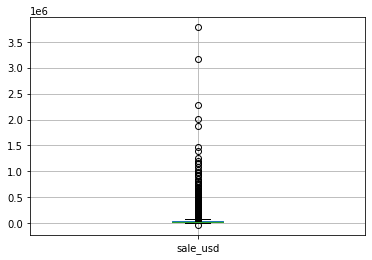

In [63]:
df.boxplot(['sale_usd'])

Так как в sale_usd большие значения (суммы заказов), можно исключить самые крупные оптовые заказы и посмотреть распределение значений. 

<AxesSubplot:>

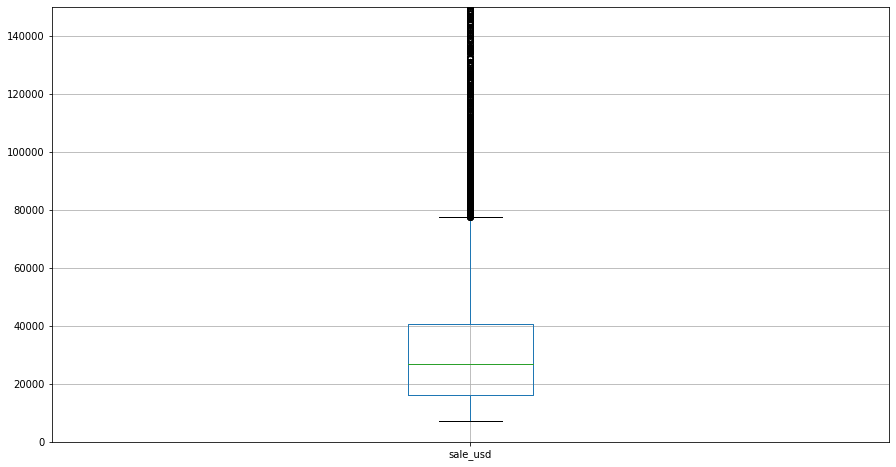

In [64]:
plt.figure(figsize=(15,8))
plt.ylim(0,150000)
df.boxplot(['sale_usd'])

KeyError: "None of [Index(['quantity'], dtype='object')] are in the [columns]"

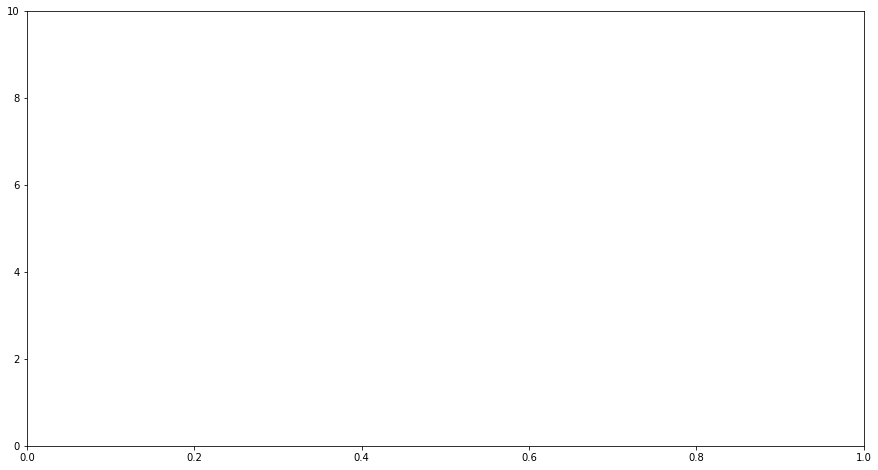

In [65]:

plt.figure(figsize=(15,8))
plt.ylim(0, 10)
df.boxplot(['quantity'])
plt.show()

In [ ]:
#исключим возврат и посомтрим базовую статистику
df[df['quantity'] != -1][['quantity', 'price_usd','sale_usd']].agg(['min', 'max', 'mean', 'median'])

,quantity,price_usd,sale_usd
min,1.000000,7100.00000,7.100000e+03
max,115.000000,328510.97060,3.778206e+06
mean,1.421467,28968.37130,3.564022e+04
median,1.000000,24816.36453,2.694638e+04


Так как среднее лучше использовать, когда нет выбросов, среднюю цену машины и цену заказа оценим по медиане.
В quantity: среднее количество машин в чеке 1, самый большой заказ 115 машин.    
В price_usd: самая дешёвая машина 7100 дол., самая дорогая 328511 дол, средняя цена авто - 27875.  
В sale_usd: 

<AxesSubplot:ylabel='Frequency'>

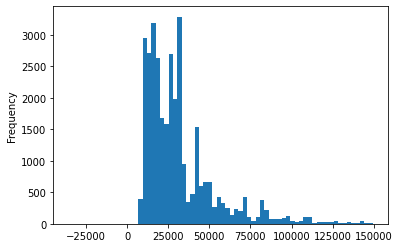

In [ ]:
df.query('sale_usd < 150000')['sale_usd'].plot(kind='hist',bins=70)

<AxesSubplot:>

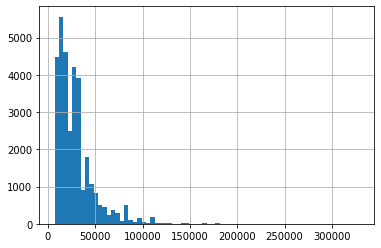

In [ ]:
df['price_usd'].hist(bins=70)

c:\Users\Redmi\anaconda3\envs\da_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Redmi\AppData\Local\Temp\ipykernel_12548\563213427.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


<AxesSubplot:>

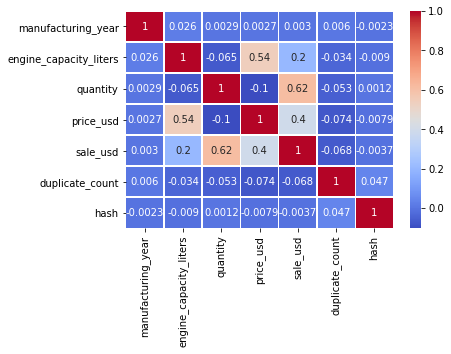

In [ ]:
import seaborn as sns
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

Есть 2 корреляции: цена автомобиля отчасти зависит от объёма двигателя (возможно, потому что чем больше объёи двигателя, тем мощнее авто, а мощность двигателя коррелирует с ценой).  
А корреляция между общей суммой заказа и количеством машин в чеке очевидна, тепловая карта просто подтвердила это.  
Остальные корреляции незначительны.  
Для нечисловых значений можно построить диаграммы рассеивания.

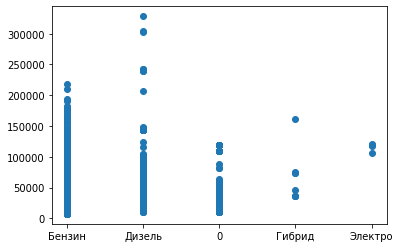

In [ ]:
plt.scatter(df['fuel_type'], df['price_usd'])

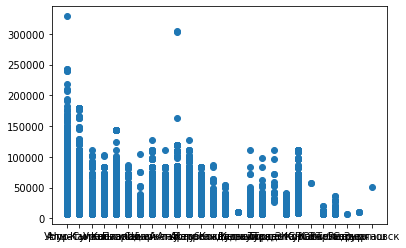

In [ ]:
plt.scatter(df['region'], df['price_usd'])

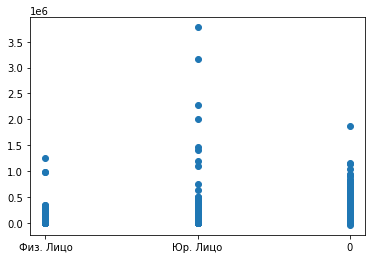

In [ ]:
plt.scatter(df['customer_type'], df['sale_usd'])

## Анализ рынка

Топовые марки на рынке Казахстана: в денежном и натуральном выражении (5-10 марок)  
Продажи на рынке Казахстана всех марок в денежном и натуральном выражении  
Динамика продаж в целом по рынку: в денежном и натуральном выражении (помесячно)  
Динамика продаж по категориям (помесячно): тип топлива, класс, сегмент  
Продажи по регионам  
Продажи по автоцентрам  
Сводные таблицы: например, объем продаж по бренду и классу авто